In [1]:
import pandas as pd
import math

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")


Propertycrime = α + Population + Population2 + Murder + Robbery

The 'population' variable is already set for you, but you will need to create the last three features. Robbery and Murder are currently continuous variables. For this model, please use these variables to create categorical features where values greater than 0 are coded 1, and values equal to 0 are coded 0. You'll use this data and model in a later assignment- for now, just write the code you need to get the data ready. Don't forget basic data cleaning procedures, either! Do some graphing to see if there are any anomalous cases, and decide how you want to deal with them.

In [2]:
df = pd.read_csv('C:\\Users\\david\Desktop\\thinkful datasets\\table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.csv', header=4,)

df
display(df.columns)

data= pd.DataFrame(df) 

needed_data = data.loc[:, ['City','Population', 'Property\ncrime','Murder and\nnonnegligent\nmanslaughter', 'Robbery','Burglary']]
needed_data.columns = ['City','Population','Property_Crime', 'Murder', 'Robbery', 'Burglary']

needed_data = needed_data.dropna()

needed_data.Robbery = needed_data.Robbery.where(needed_data.Robbery == 0, 1)
needed_data.Murder = needed_data.Murder.where(needed_data.Murder == 0, 1)

needed_data["population2"] = needed_data["Population"]**2

needed_data = needed_data[np.abs(needed_data.Population-needed_data.Population.mean())<=(2*needed_data.Population.std())] #keep only the ones that are within +3 to -3 standard deviations in the column 'Data'.

needed_data.head(5)

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3'],
      dtype='object')

,City,Population,Property_Crime,Murder,Robbery,Burglary,population2
0,Adams Village,1861.000,12.000,0.000,0.000,2.000,3463321.000
1,Addison Town and Village,2577.000,24.000,0.000,0.000,3.000,6640929.000
2,Akron Village,2846.000,16.000,0.000,0.000,1.000,8099716.000
3,Albany,97956.000,4090.000,1.000,1.000,705.000,9595377936.000
4,Albion Village,6388.000,223.000,0.000,1.000,53.000,40806544.000


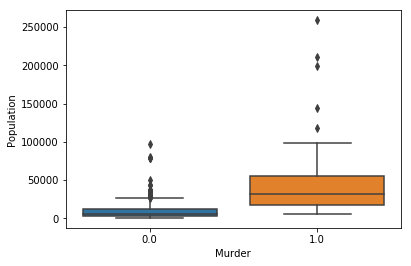

In [3]:
sns.boxplot(
    needed_data.Murder,
    needed_data.Population,
)
plt.xlabel('Murder')
plt.ylabel('Population')
plt.show()

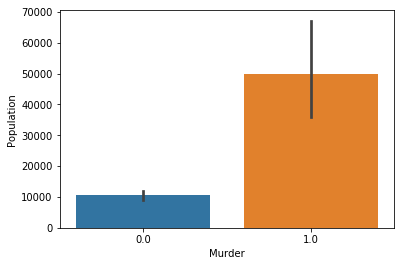

In [4]:
sns.barplot(x='Murder', y='Population', data=needed_data)
plt.show()

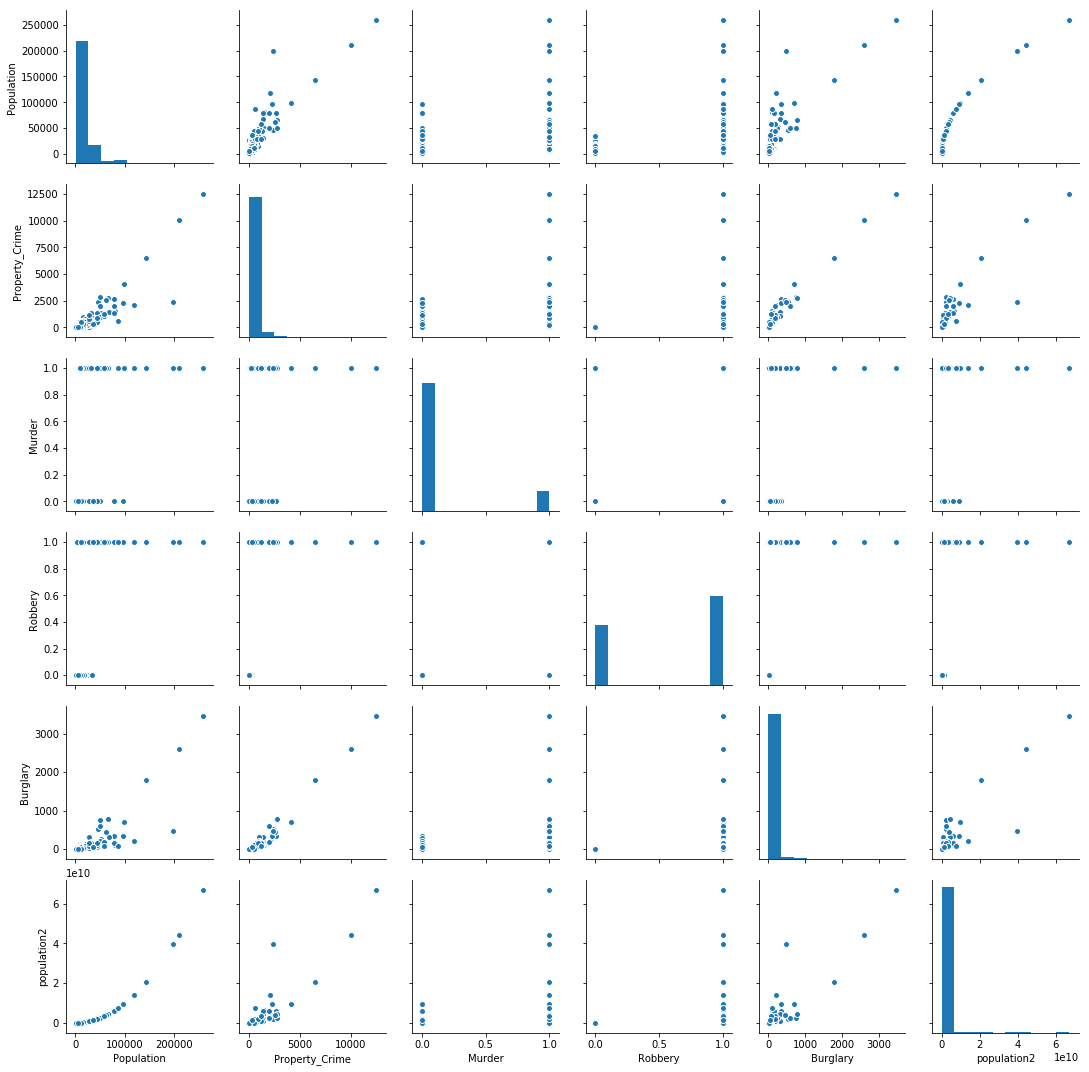

In [5]:
sns.pairplot(needed_data)

In [6]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = needed_data['Property_Crime'].values.reshape(-1, 1)
X = needed_data[['Population','Robbery','Murder', 'Burglary']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[9.43446764e-03 6.25784109e+01 4.95287897e+00 2.99691963e+00]]

Intercept: 
 [-19.28319047]

R-squared:
0.9774741731454328


In [7]:
# Fit the model to our data using the formula.
lm = smf.ols('Property_Crime ~ Population+Robbery+Murder+Burglary', data=needed_data).fit()

In [8]:
lm.params

Intercept    -19.283
Population     0.009
Robbery       62.578
Murder         4.953
Burglary       2.997
dtype: float64

In [9]:
lm.pvalues

Intercept    0.152
Population   0.000
Robbery      0.001
Murder       0.862
Burglary     0.000
dtype: float64

In [10]:
lm.rsquared

0.977474173145433

### Now let's examine the Multivariate Normality.
The error from the model (calculated by subtracting the model-predicted values from the real outcome values) should be normally distributed. Since ordinary least squares regression models are fitted by choosing the parameters that best minimize error, skewness or outliers in the error can result in serious miss-estimations.

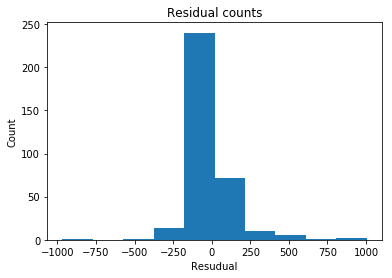

In [11]:

# Extract predicted values.# Extract 
predicted = regr.predict(X).ravel()
actual = needed_data['Property_Crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Resudual')
plt.ylabel('Count')
plt.show()




We are looking for a normal distribution for the residuals and have not achieved that. Therefore, we will need to do some transformations

### Homoscedasticity
The distribution of your error terms (its "scedasticity"), should be consistent for all predicted values, or homoscedastic.

For example, if your error terms aren't consistently distributed and you have more variance in the error for large outcome values than for small ones, then the confidence interval for large predicted values will be too small because it will be based on the average error variance. This leads to overconfidence in the accuracy of your model's predictions.

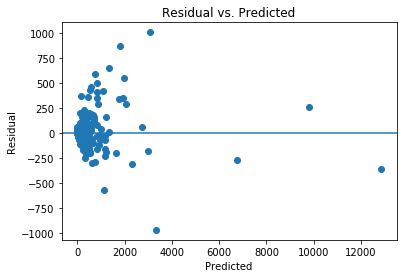

In [12]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### Transformations
As showed above with the p-value calculation, Murder is insignficant when it comes to predicting Property Crime. we will do our first transformation by removing it from the model

In [13]:
# Instantiate and fit our model without Murder.
regr2 = linear_model.LinearRegression()
Y = needed_data['Property_Crime'].values.reshape(-1, 1)
X2 = needed_data[['Population','Robbery', 'Burglary']]
regr2.fit(X2, Y)

# Inspect the results.
print('\nCoefficients: \n', regr2.coef_)
print('\nIntercept: \n', regr2.intercept_)
print('\nR-squared:')
print(regr2.score(X2, Y))


Coefficients: 
 [[9.46236207e-03 6.31254818e+01 2.99697961e+00]]

Intercept: 
 [-19.37542499]

R-squared:
0.9774721838032118


In [14]:
# Fit the model to our data using the formula.
lm2 = smf.ols('Property_Crime ~ Population+Robbery+Burglary', data=needed_data).fit()

In [15]:
lm2.pvalues

Intercept    0.150
Population   0.000
Robbery      0.001
Burglary     0.000
dtype: float64

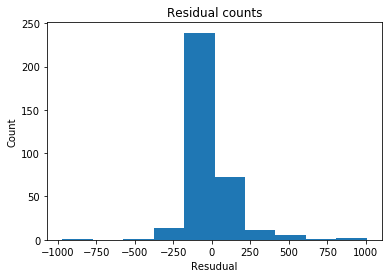

In [16]:

# Extract predicted values.# Extract 
predicted2 = regr2.predict(X2).ravel()
actual = needed_data['Property_Crime']

# Calculate the error, also called the residual.
residual2 = actual - predicted2

# This looks a bit concerning.
plt.hist(residual2)
plt.title('Residual counts')
plt.xlabel('Resudual')
plt.ylabel('Count')
plt.show()

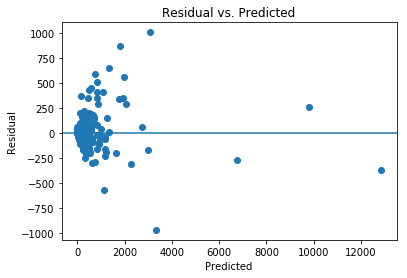

In [17]:
plt.scatter(predicted2, residual2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

The above transformation removing the Murder Column had no effect. We are going to look at other ways of transforming the data.

In [19]:
needed_data['population_log'] =[math.log(x) for x in  needed_data['Population']]
needed_data['population_log']

0      7.529
1      7.854
2      7.954
3     11.492
4      8.762
5      8.316
6      7.485
7     11.681
8      9.161
9      9.808
10     7.627
11     8.417
12     6.489
13     7.833
14    10.214
15     8.112
16     8.919
17     8.597
18     9.640
19     8.654
20     9.777
21    10.441
22    10.743
23     7.251
24     9.393
25     6.930
26     7.751
27     7.628
28     7.633
29     7.766
       ...  
318    8.200
319    6.422
320    9.409
321   11.030
322   10.239
323    8.837
324   10.238
325    8.010
326    8.147
327    8.670
328    9.035
329    8.552
330   10.246
331    9.235
332    7.529
333    8.375
334   10.687
335    7.494
336    8.428
337    7.457
338   10.710
339    7.865
340   10.961
341    8.225
342    9.121
343    9.277
344    6.720
345    8.688
346   12.202
347   10.509
Name: population_log, Length: 347, dtype: float64

Let's change the population to log and see how everything changes

In [21]:
# Instantiate and fit our model without Murder.
regr3 = linear_model.LinearRegression()
Y = needed_data['Property_Crime'].values.reshape(-1, 1)
X3 = needed_data[['population_log','Robbery', 'Burglary']]
regr3.fit(X3, Y)

# Inspect the results.
print('\nCoefficients: \n', regr3.coef_)
print('\nIntercept: \n', regr3.intercept_)
print('\nR-squared:')
print(regr3.score(X3, Y))


Coefficients: 
 [[119.69422938   8.72854006   3.56863323]]

Intercept: 
 [-946.61951484]

R-squared:
0.9694859195213451


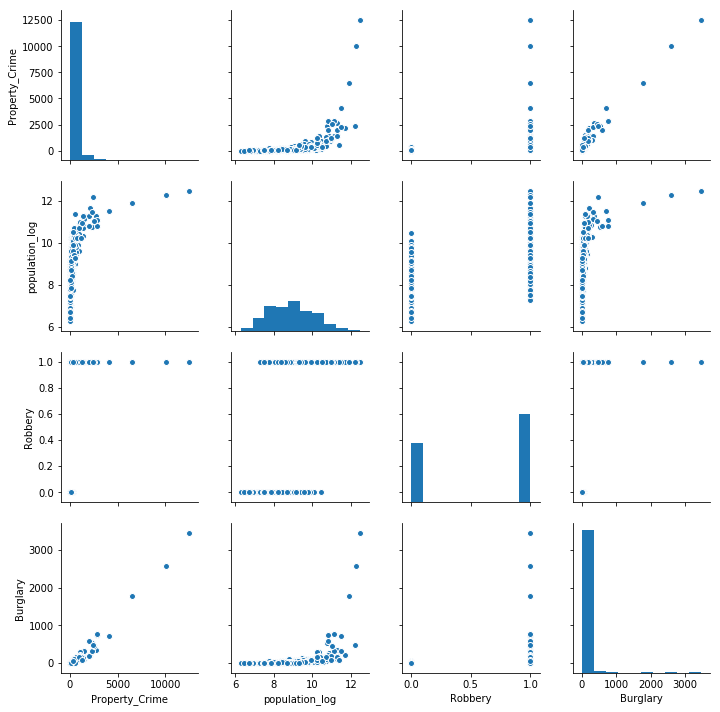

In [24]:
sns.pairplot(needed_data[['Property_Crime','population_log','Robbery', 'Burglary']])

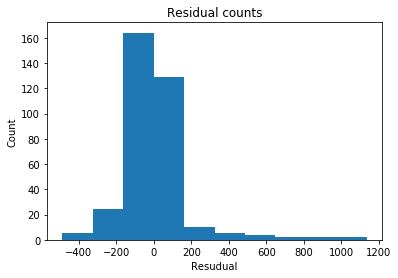

In [26]:

# Extract predicted values.# Extract 
predicted3 = regr3.predict(X3).ravel()
actual = needed_data['Property_Crime']

# Calculate the error, also called the residual.
residual3 = actual - predicted3

# This looks a bit concerning.
plt.hist(residual3)
plt.title('Residual counts')
plt.xlabel('Resudual')
plt.ylabel('Count')
plt.show()

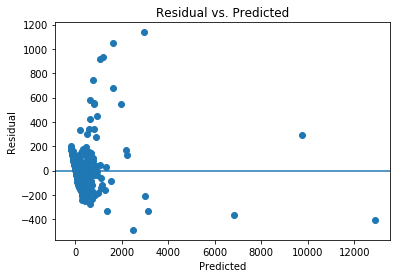

In [27]:
plt.scatter(predicted3, residual3)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [28]:
needed_data['burg_sqrt'] =[math.sqrt(x) for x in  needed_data['Burglary']]
needed_data['burg_sqrt']

0      1.414
1      1.732
2      1.000
3     26.552
4      7.280
5      3.162
6      0.000
7     14.283
8      4.000
9      9.950
10     1.732
11     2.000
12     0.000
13     0.000
14    11.489
15     1.732
16     3.162
17     4.000
18    10.149
19     5.657
20     5.099
21     7.071
22    22.913
23     1.414
24     4.472
25     1.414
26     2.000
27     2.449
28     3.000
29     1.732
       ...  
318    4.690
319    0.000
320    5.000
321   21.190
322    6.245
323    3.606
324    9.539
325    4.243
326    2.236
327    2.236
328    2.449
329    4.796
330   13.000
331    7.616
332    3.162
333    3.000
334   10.050
335    2.236
336    5.657
337    2.000
338   12.884
339    3.464
340    8.775
341    3.742
342    3.606
343    3.000
344    2.828
345    3.606
346   21.679
347    6.708
Name: burg_sqrt, Length: 347, dtype: float64

In [29]:
# Instantiate and fit our model without Murder.
regr4 = linear_model.LinearRegression()
Y = needed_data['Property_Crime'].values.reshape(-1, 1)
X4 = needed_data[['population_log','Robbery', 'burg_sqrt']]
regr4.fit(X4, Y)

# Inspect the results.
print('\nCoefficients: \n', regr4.coef_)
print('\nIntercept: \n', regr4.intercept_)
print('\nR-squared:')
print(regr4.score(X4, Y))


Coefficients: 
 [[-153.07821562 -233.51231992  181.43741512]]

Intercept: 
 [845.13380225]

R-squared:
0.8773204616777767


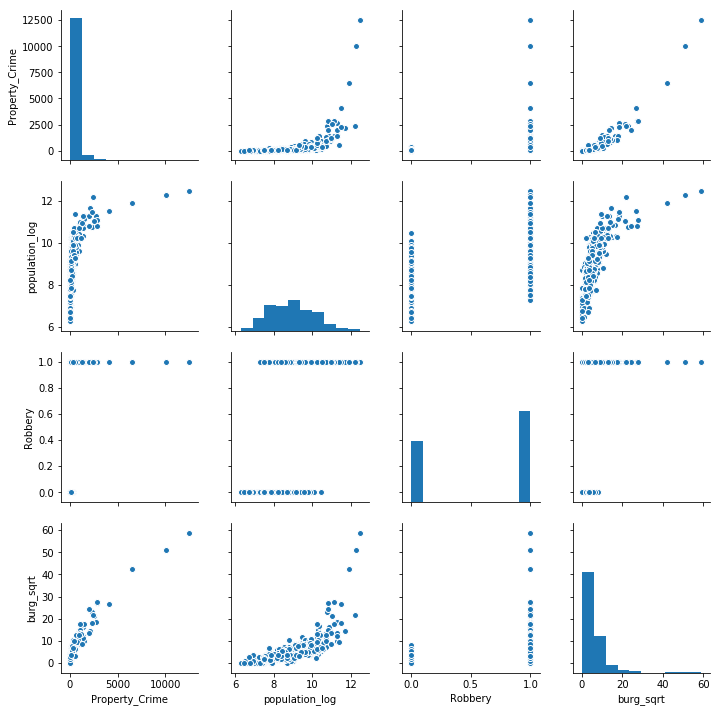

In [31]:
sns.pairplot(needed_data[['Property_Crime','population_log','Robbery', 'burg_sqrt']])

In [32]:
# Fit the model to our data using the formula.
lm3 = smf.ols('Property_Crime ~ population_log+Robbery+burg_sqrt', data=needed_data).fit()

In [34]:
lm3.pvalues

Intercept        0.000
population_log   0.000
Robbery          0.000
burg_sqrt        0.000
dtype: float64

##### Still looks funky let's try trnsforming the outcome variable, property crime.

In [35]:
needed_data['Property_Crime_sqrt'] =[math.sqrt(x) for x in  needed_data['Property_Crime']]
needed_data['Property_Crime_sqrt']

0      3.464
1      4.899
2      4.000
3     63.953
4     14.933
5      6.782
6      3.162
7     46.022
8     14.491
9     20.125
10     6.245
11     5.745
12     1.414
13     2.236
14    29.309
15     5.000
16     9.381
17     9.695
18    23.643
19    13.820
20    12.490
21    21.024
22    48.466
23     3.742
24     9.950
25     2.000
26     4.899
27     4.472
28     5.568
29     3.606
       ...  
318    9.110
319    0.000
320   20.905
321   50.279
322   23.896
323   11.916
324   27.695
325    8.246
326    8.832
327    7.616
328    7.681
329   13.928
330   34.132
331   15.556
332    9.592
333    7.348
334   21.656
335    5.000
336   12.806
337    6.633
338   29.933
339    7.874
340   35.100
341    6.000
342    8.775
343   23.259
344    4.123
345    7.616
346   48.662
347   18.276
Name: Property_Crime_sqrt, Length: 347, dtype: float64

In [37]:
# Instantiate and fit our model without Murder.
regr5 = linear_model.LinearRegression()
Y2 = needed_data['Property_Crime_sqrt'].values.reshape(-1, 1)
X5 = needed_data[['population_log','Robbery', 'burg_sqrt']]
regr5.fit(X5, Y2)

# Inspect the results.
print('\nCoefficients: \n', regr5.coef_)
print('\nIntercept: \n', regr5.intercept_)
print('\nR-squared:')
print(regr5.score(X5, Y2))


Coefficients: 
 [[2.09774091 1.30848956 1.71927239]]

Intercept: 
 [-15.00387873]

R-squared:
0.9502375698916465


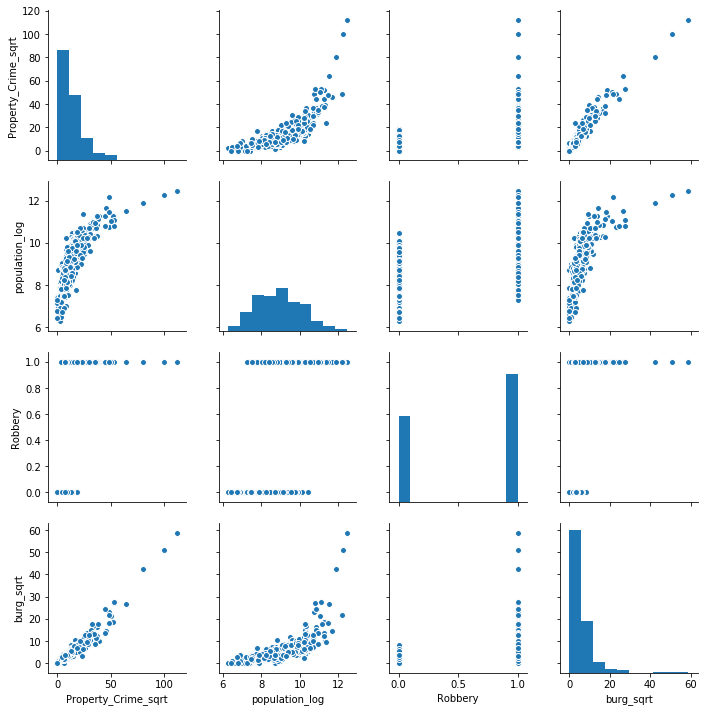

In [38]:
sns.pairplot(needed_data[['Property_Crime_sqrt','population_log','Robbery', 'burg_sqrt']])

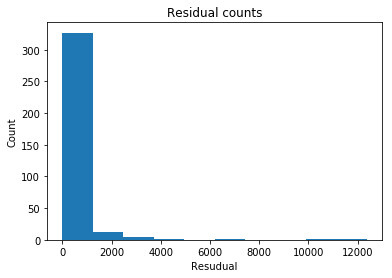

In [39]:

# Extract predicted values.# Extract 
predicted5 = regr5.predict(X5).ravel()
actual = needed_data['Property_Crime']

# Calculate the error, also called the residual.
residual5 = actual - predicted5

# This looks a bit concerning.
plt.hist(residual5)
plt.title('Residual counts')
plt.xlabel('Resudual')
plt.ylabel('Count')
plt.show()

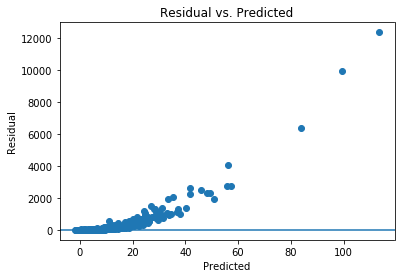

In [40]:
plt.scatter(predicted5, residual5)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [43]:
correlation_matrix = X5.corr()
display(correlation_matrix)

,population_log,Robbery,burg_sqrt
population_log,1.000,0.597,0.724
Robbery,0.597,1.000,0.441
burg_sqrt,0.724,0.441,1.000


It seems that there are outliers larger than NYC making the data skewed